In [ ]:
import time
import os
import numpy as np
import torch
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torch.nn as nn
drive.mount('/content/gdrive')
torch.manual_seed(0)

Mounted at /content/gdrive


In [ ]:

path = "/content/gdrive/MyDrive/APS360/360Project/final_dataset"
train_dir = os.path.join(path, 'train/')
val_dir = os.path.join(path, 'val/')
#test_dir = '/content/gdrive/MyDrive/APS360/360Project/maxres_thumbnails/test'
classes =['Autos & Vehicles','Food & Drink','Pets & Animals','Science & Education','Sports']
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])
train_set = datasets.ImageFolder(train_dir, transform=data_transform)
validation_set = datasets.ImageFolder(val_dir, transform=data_transform)
#test_set = datasets.ImageFolder(test_dir, transform=data_transform)
#Make a quick and small dataset
train_set,other_dataset = random_split(dataset=train_set,lengths=[3000,3000])
validation_set,test_set = random_split(dataset=validation_set,lengths=[750,750]) #This is half of the dataset

In [ ]:
#Take in data
# Train : Validation : Test = 2:1:1
#path = "/content/gdrive/MyDrive/APS360/360Project/small_test"
#file_name = os.listdir(path)
#count_pic = 0
#for files in file_name:
#  count_pic+=len(os.listdir(path+"/"+files))
#train_index = count_pic//2
#validation_index = count_pic//4
#test_index = count_pic - train_index - validation_index

In [ ]:
#data_dir = "/content/gdrive/MyDrive/APS360/360Project/small_test"
#classes = ['Arts _ Entertainment','Autos _ Vehicles','Beauty _ Fitness','Food _ Drink','Games','Sports']
#data_transform = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])
#total_data = datasets.ImageFolder(data_dir, transform=data_transform)
#train_set,other_dataset = random_split(dataset=total_data,lengths=[train_index,count_pic-train_index])
#validation_set,test_set = random_split(dataset=other_dataset,lengths=[validation_index,test_index])

In [ ]:
print('Num training images: ', len(train_set))
print('Num validation images: ', len(validation_set))
#print('Num test images: ', len(test_set))

Num training images:  3000
Num validation images:  750


In [ ]:
# define dataloader parameters
batch_size  = 128
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,num_workers=num_workers, shuffle=True)


In [ ]:
#!pip install numba

#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [ ]:
#Model CNN 
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.conv3 = nn.Conv2d(10, 20, 4)
        self.conv4 = nn.Conv2d(20, 40, 4)
        self.fc1 = nn.Linear(4840, 320)
        self.fc2 = nn.Linear(320, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 4840)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        return x


In [ ]:
#Model Transferlearning+ANN Classifier
# Alexnet

import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
features = alexNet.features(images)
features.shape

In [ ]:
# VGGnet
vggNet = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
features = vggNet.features(images)
features.shape

In [ ]:
# ResNet
#resNet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resNet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
features = resNet(images)
features.shape

In [ ]:
#GoogleENET
googleNet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
#dataiter = iter(train_loader)
#images, labels = dataiter.next()
#features = googleNet(images)
#features.shape

In [ ]:
#EfficientNet
!pip install --upgrade efficientnet-pytorch
from efficientnet_pytorch import EfficientNet
effNet = EfficientNet.from_pretrained('efficientnet-b0')
dataiter = iter(train_loader)
images, labels = dataiter.next()
features = effNet(images)
features.shape

In [ ]:
#Xeception
!pip install timm
import timm
xcep = timm.create_model('xception', pretrained=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
features = xcep(images)
features.shape

In [ ]:
#Artifical Neural Network Architecture (alexNet)
ALNC = alexNet.features

class ANNClassifier_ALNC(nn.Module):
    def __init__(self):
        super(ANNClassifier_ALNC, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#Artifical Neural Network Architecture (vggNet)
VGG = vggNet.features
class ANNClassifier_VGG(nn.Module):
    def __init__(self):
        super(ANNClassifier_VGG, self).__init__()
        self.fc1 = nn.Linear(512 * 7 * 7, 10)
        self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 512 * 7 * 7) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#Artifical Neural Network Architecture (resNet)
RES = resNet
class ANNClassifier_RES(nn.Module):
    def __init__(self):
        super(ANNClassifier_RES, self).__init__()
        self.fc1 = nn.Linear(1000, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 1000) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
#Artifical Neural Network Architecture (GoogleNet)
Google = googleNet
class ANNClassifier_GOOGLE(nn.Module):
    def __init__(self):
        super(ANNClassifier_GOOGLE, self).__init__()
        self.fc1 = nn.Linear(1000, 6)
        #self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 1000) #flatten feature data
        x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return x

In [ ]:
#Artifical Neural Network Architecture (EfficientNet)
EFF = effNet
class ANNClassifier_EFF(nn.Module):
    def __init__(self):
        super(ANNClassifier_EFF, self).__init__()
        self.fc1 = nn.Linear(1000, 10)
        self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 1000) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#Artifical Neural Network Architecture (Exception)
EXP = xcep
class ANNClassifier_EXP(nn.Module):
    def __init__(self):
        super(ANNClassifier_EXP, self).__init__()
        self.fc1 = nn.Linear(1000, 10)
        self.fc2 = nn.Linear(10, 6)

    def forward(self, x):
        x = x.view(-1, 1000) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Helper function

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        #改这里 change here to switch model
        output = model(Google(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Train code


In [ ]:
def train(model, data, lr,batch_size=20, num_epochs=1,train_loader=train_loader):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
          #### VGG is vggNet.fearures (VggNet without classifier) ####
          #### RES is resNet
          #改这里 change here to switch model
            out = model(Google(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/gdrive/MyDrive/APS360/360Project/Models/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

Tesla T4
CUDA is available!  Training on GPU ...
Iteration:  1 Progress:   0.21  % Time Elapsed:  709.49 s 
Iteration:  2 Progress:   0.42  % Time Elapsed:  810.11 s 
Iteration:  3 Progress:   0.62  % Time Elapsed:  903.90 s 
Iteration:  4 Progress:   0.83  % Time Elapsed:  1002.12 s 
Iteration:  5 Progress:   1.04  % Time Elapsed:  1099.21 s 
Iteration:  6 Progress:   1.25  % Time Elapsed:  1193.98 s 
Iteration:  7 Progress:   1.46  % Time Elapsed:  1289.38 s 
Iteration:  8 Progress:   1.67  % Time Elapsed:  1389.08 s 
Iteration:  9 Progress:   1.88  % Time Elapsed:  1493.11 s 
Iteration:  10 Progress:   2.08  % Time Elapsed:  1585.12 s 
Iteration:  11 Progress:   2.29  % Time Elapsed:  1681.94 s 
Iteration:  12 Progress:   2.50  % Time Elapsed:  1785.89 s 
Iteration:  13 Progress:   2.71  % Time Elapsed:  1880.93 s 
Iteration:  14 Progress:   2.92  % Time Elapsed:  1966.66 s 
Iteration:  15 Progress:   3.12  % Time Elapsed:  2065.69 s 
Iteration:  16 Progress:   3.33  % Time Elapsed:

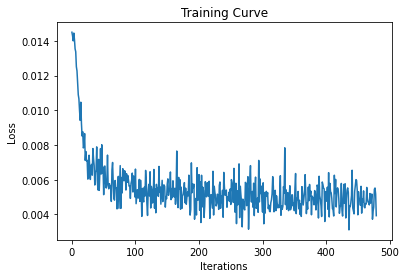

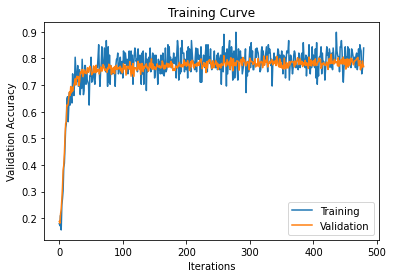

Final Training Accuracy: 0.7876666666666666
Final Validation Accuracy: 0.7693333333333333
Total time:   10435.61 s  Time per Epoch:  521.78 s 


In [ ]:
use_cuda = True
#model = ANNClassifier_ALNC()
#model = ANNClassifier_VGG()
#model = ANNClassifier_EFF()
#model = ANNClassifier_EXP()
model = ANNClassifier_GOOGLE()
#model = ANNClassifier_RES()
if use_cuda and torch.cuda.is_available():
  #ALNC.cuda()
  #VGG.cuda()
  #RES.cuda()
  model.cuda()
  Google.cuda()
  #EFF.cuda()
  #EXP.cuda()
  print(torch.cuda.get_device_name(0))
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model, [],lr=0.001, batch_size=batch_size, num_epochs=20, train_loader=train_loader)

In [ ]:
model_path = get_model_name("google", batch_size=128, learning_rate=0.001, epoch=5)
torch.save(model.state_dict(), model_path)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,num_workers=num_workers, shuffle=True)

def get_test_accuracy(model):
    data_loader = test_loader
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        #改这里 change here to switch model
        output = model(Google(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
get_test_accuracy(model)

0.10344827586206896

AlexNet:

Final Training Accuracy: 0.6310344827586207

Final Validation Accuracy: 0.36551724137931035

Total time:   61.06 s  Time per Epoch:   6.11 s

----------------
VggNet:

Final Training Accuracy: 0.7310344827586207

Final Validation Accuracy: 0.3793103448275862

Total time:   90.87 s  Time per Epoch:   9.09 s

----------------
ResNet 18:

Final Training Accuracy: 0.7137931034482758

Final Validation Accuracy: 0.4896551724137931

Total time:   57.84 s  Time per Epoch:   5.78 s

----------------
ResNet 152:

Final Training Accuracy: 0.7551724137931034

Final Validation Accuracy: 0.5310344827586206

Total time:   153.14 s  Time per Epoch:  15.31 s

----------------

GoogleNet:

Final Training Accuracy: 0.7103448275862069

Final Validation Accuracy: 0.5379310344827586

Total time:   82.32 s  Time per Epoch:   8.23 s

----------
Efficient Net:
Base-model

Final Training Accuracy: 0.7137931034482758

Final Validation Accuracy: 0.5103448275862069

Total time:   130.57 s  Time per Epoch:  13.06 s

B5 and above models takes way too much GPU RAM in current
setting. Even A100 40GB is not enough, so I won't test them for now

----------
Xception: bach_size = 16 due to limited GPU RAM

Final Training Accuracy: 0.6724137931034483

Final Validation Accuracy: 0.3793103448275862

Total time:   360.96 s  Time per Epoch:  36.10 s 
